# En este notebook se desarrolla un modelo para predecir precios de vivienda
Se realiza un algoritmo para generar una variable auxiliar que obtiene la menor distancia de cada inmueble a puntos de interes listados en la db "PuntosInteres.csv"

#### Instalación XGBOOST
Se realiza la instalación de la librería XGBOOST para entrenar un modelo tipo boosting para realizar la regresión

In [107]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 10.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


## Llamado a librerías

In [118]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from math import sin, cos, sqrt, atan2, radians

from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor 
import xgboost as xgb

# Algoritmo para calcular la menor distancia en kilometros para cada inmueble con los puntos de interes

Obteniendo las distancias de cada coordenada con los puntos de interes dados utilizando el radio de la tierra y la transformación:

$R = radio de la tierra$

$dif_{lat} = lat1 - lat2$

$dif_{long} = long1 - long2$

$ a = sin(\frac{dif_{lat}}{2})^{2} + cos(lat1) * sin(\frac{dif_{long}}{2}) ^{2}$

$ C = 2 * arctan(\frac{\sqrt{a}}{\sqrt{1-a}})$

$ d = R*c $ 

$ d = distancia en kilometros $



In [54]:
def funcion_distancia_puntosinteres(df,df_puntos):

    radio_tierra = 6373.0

    menores = []

    for i in tqdm(range(0,df.shape[0])):

        menor = 99999999999999

        for j in range(0,df_puntos.shape[0]):
            
            lon1 = df.loc[i]['Longitud']
            lat1 = df.loc[i]['Latitud']

            lon2 = df_puntos.loc[j][0]
            lat2 = df_puntos.loc[j][1]

            lat1 = radians(lat1)
            lon1 = radians(lon1)
            lat2 = radians(lat2)
            lon2 = radians(lon2)

            dlon = lon2 - lon1
            dlat = lat2 - lat1

            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))

            distance = radio_tierra * c

            if distance < menor:
                menor = distance
        
        menores.append(menor)

    return menores

### Puntos de interés

In [59]:
df_puntos = pd.read_csv('../Data/PuntosInteres.csv', sep=';',encoding='latin1')
cols_puntos = ['Longitud', 'Latitud', 'Centro', 'Info']
df_puntos.columns = cols_puntos
df_puntos

,Longitud,Latitud,Centro,Info
0,-75.556054,10.396154,pharmacy,No hallado
1,-75.561023,10.394204,pharmacy,No hallado
2,-74.206402,4.715360,pharmacy,DroguerÐa Colsubsidio Funza
3,-75.578630,6.184220,pharmacy,Farmacia Pasteur
4,-74.056567,4.704550,pharmacy,No hallado
...,...,...,...,...
39894,-74.502631,4.340704,platform,Parada Albania
39895,-74.022348,4.664206,platform,San luis ligne 4 to Bogota
39896,-75.658282,4.674668,platform,Willys hacia Salento
39897,-75.658789,4.674811,platform,"Willys hacia Quimbaya, Ulloa, Cauchera"


In [60]:
df_puntos.Centro.value_counts()

restaurant         7237
school             4584
supermarket        2394
pharmacy           2217
cafe               1980
                   ... 
gambling              2
swingerclub           1
social_centre         1
planetarium           1
animal_boarding       1
Name: Centro, Length: 84, dtype: int64

In [61]:
lista_centros = ['bank', 'embassy', 'cinema']
df_puntos = df_puntos[df_puntos['Centro'].isin(lista_centros)]

### Dataset Principal

In [15]:
df = pd.read_csv('../Data/train_precios_vivienda.csv', quotechar='"', decimal=",")
df.head(2)

/tmp/ipykernel_7461/1876536623.py:1: DtypeWarning: Columns (67,109,110,160,168,169,170,171,178,180,206,210,212,216) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/train_precios_vivienda.csv', quotechar='"', decimal=",")


,Unnamed: 0,id,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,...,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
0,4112,5896,43090.6247474074,Remate,Remates,GarantÃ­a Hipotecaria,Remates,Vivienda,NaN,VALLE DEL CAUCA,...,81968750.0,0,0.0,0,0.0,"145318750,00",2522304,"576134,95",0.0,0.0
1,7401,10570,NaN,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,QUINDÃO,...,0.0,157,78500000.0,No,0.0,713986654,257.23250000000002,2775647.14,-75.661152,4.5440265


In [56]:
df.shape

(11571, 222)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11571 entries, 0 to 11570
Columns: 222 entries, Unnamed: 0 to Latitud
dtypes: float64(1), int64(18), object(203)
memory usage: 19.6+ MB


In [22]:
df = df.fillna(0)
df_strings = df.loc[:, df.dtypes == object]
df_strings

,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,barrio,...,area_construccion,valor_area_construccion,area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
0,43090.6247474074,Remate,Remates,GarantÃ­a Hipotecaria,Remates,Vivienda,0,VALLE DEL CAUCA,TULUA,VICTORIA,...,"131,15",81968750.0,0,0,0.0,"145318750,00",2522304,"576134,95",0.0,0.0
1,0,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,0,QUINDÃO,ARMENIA,SECTOR CLINICAS,...,0,0.0,157,No,0.0,713986654,257.23250000000002,2775647.14,-75.661152,4.5440265
2,0,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,0,ANTIOQUIA,MEDELLIN,ROBLEDO PILARICA,...,0,0.0,0,Si,0.0,270500000,259.4264,1042684.94,-75.5841161,6.2770197
3,43091.6761393519,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,VIS,CUNDINAMARCA,SOACHA,CIUDAD VERDE,...,0,0.0,0,No,0.0,"84840000,00",252245,"336339,67",0.0,0.0
4,0,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,VIS,META,GRANADA,BULEVAR ETAPA II,...,84.52,69306400.0,0,0,0.0,96346400,259.72770000000003,370951.58,-73.71237,3.565757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11566,0,OriginaciÃ³n,Leasing Habitacional,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,0,"BOGOTÃ, D. C.","BOGOTÃ, D. C.",Country Club,...,0,0,0,No,0,709028000,259.57420000000002,2731504.13,-74.0478446,4.7115785
11567,43157.0,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,0,ANTIOQUIA,MEDELLIN,BOYACA LAS BRISAS,...,0,0,0,Si,2193300,158356260,254.18279999999999,623001.48,-74.6104578,10.4637422
11568,0,OriginaciÃ³n,Leasing Habitacional,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,0,"BOGOTÃ, D. C.","BOGOTÃ, D. C.",Normandia,...,0,0,0,No,0,572610000,254.4109,2250729.04,-74.1096521,4.674083
11569,42999.4291148611,Originación,Crédito hipotecario de vivienda,Garantía Hipotecaria,Hipotecario,Vivienda,0,"BOGOTÁ, D. C.","BOGOTÁ, D. C.",Los Molinos - Rafeal U. U.,...,"115,39","97997000,00",0,0,0,"183290000,00",2517095,"728214,55",0.0,0.0


In [59]:
df.iloc[: , -20:]

,concepto_del_metodo_9,area_privada,valor_area_privada,area_garaje,valor_area_garaje,area_deposito,valor_area_deposito,area_terreno,valor_area_terreno,area_construccion,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
0,0,0,0,0,0,0,0,"253,4",63350000.0,"131,15",81968750.0,0,0.0,0,0.0,"145318750,00",2522304,"576134,95",0.0,0.0
1,0,254.98,635486654,0,0,0,0,0,0.0,0,0.0,157,78500000.0,No,0.0,713986654,257.23250000000002,2775647.14,-75.661152,4.5440265
2,0,82,246000000,13.21,22000000,1.02,2500000,0,0.0,0,0.0,0,0.0,Si,0.0,270500000,259.4264,1042684.94,-75.5841161,6.2770197
3,0,"48,48","84840000,00",0,0,0,0,0,0.0,0,0.0,0,0.0,No,0.0,"84840000,00",252245,"336339,67",0.0,0.0
4,0,0,0,0,0,0,0,104,27040000.0,84.52,69306400.0,0,0.0,0,0.0,96346400,259.72770000000003,370951.58,-73.71237,3.565757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11566,0,128.30000000000001,662028000,21.75,42000000.0,2.09,5000000,0,0,0,0,0,0.0,No,0,709028000,259.57420000000002,2731504.13,-74.0478446,4.7115785
11567,0,64.08,156162960,0,0.0,0,0,0,0,0,0,0,0.0,Si,2193300,158356260,254.18279999999999,623001.48,-74.6104578,10.4637422
11568,0,190.87,572610000,0,0.0,0,0,0,0,0,0,0,0.0,No,0,572610000,254.4109,2250729.04,-74.1096521,4.674083
11569,0,0,0,0,0.0,0,0,"65,61","85293000,00","115,39","97997000,00",0,0.0,0,0,"183290000,00",2517095,"728214,55",0.0,0.0


## Limpieza de datos

In [23]:
def limpieza1(df):
    
    for column in df:

        if df[column].dtype.name == 'object':
            df[column] = df[column].str.replace(',', '.')

        try:
            df[column] = df[column].astype(float)
        except:
            pass 

    return df

df = limpieza1(df)

In [24]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11571 entries, 0 to 11570
Columns: 222 entries, Unnamed: 0 to Latitud
dtypes: float64(36), object(186)
memory usage: 19.6+ MB


In [25]:
df.Latitud.dtype

dtype('float64')

### Exploración externa para descartar variables y reducir la dimensionalidad

In [26]:
df_cols = pd.read_csv('../Data/Variables_Descartadas.csv', sep=';')

variables = [i for i in df_cols]

df = df[variables]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11571 entries, 0 to 11570
Data columns (total 78 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11571 non-null  float64
 1   fecha_aprobación         4797 non-null   float64
 2   objeto                   11571 non-null  object 
 3   motivo                   11571 non-null  object 
 4   proposito                11571 non-null  object 
 5   tipo_avaluo              11571 non-null  object 
 6   tipo_credito             11571 non-null  object 
 7   tipo_subsidio            1352 non-null   object 
 8   departamento_inmueble    11571 non-null  object 
 9   municipio_inmueble       11571 non-null  object 
 10  barrio                   11565 non-null  object 
 11  sector                   11570 non-null  object 
 12  vias_pavimentadas        11571 non-null  object 
 13  sardineles_en_las_vias   11571 non-null  object 
 14  andenes_en_las_vias   

### Función de limpieza dependiendo la naturaleza de la variable

In [62]:
correccion_variables = {
    "estrato": "entero",
    "alcantarillado_en_el_sector": "binario",
    "acueducto_en_el_sector": "binario",
    "gas_en_el_sector": "binario",
    "energia_en_el_sector": "binario",
    "telefono_en_el_sector": "binario",
    "vias_pavimentadas": "binario",
    "sardineles_en_las_vias": "binario",
    "andenes_en_las_vias": "binario",
    "paradero": "binario",
    "alumbrado": "binario",
    "arborizacion": "binario",
    "alamedas": "binario",
    "gas_en_el_predio": "binario",
    "energia_en_el_predio": "binario",
    "telefono_en_el_predio": "binario",
    "numero_piso": "entero",
    "piscina": "binario",
    "tanque_de_agua": "binario",
    "garaje_visitantes": "binario",
    "teatrino": "binario",
    "sauna": "binario",
    "vigilancia_privada": "binario",
    "tipo_vigilancia": "binario",
    "administracion": "binario",
    "habitaciones": "entero",
    "estar_habitacion": "entero",
    "cuarto_servicio": "entero",
    "closet": "entero",
    "sala": "entero",
    "comedor": "entero",
    "bano_privado": "entero",
    "bano_social": "entero",
    "bano_servicio": "entero",
    "cocina": "entero",
    "estudio": "entero",
    "balcon": "entero",
    "terraza": "entero",
    "patio_interior": "entero",
    "jardin": "entero",
    "zona_de_ropas": "entero",
    "zona_verde_privada": "entero",
    "local": "entero",
    "oficina": "entero",
    "bodega": "entero",
}

def corregir_variables(df, diccionario):

    for i in df:
        if i in diccionario:
            valor = diccionario[i]
            if valor == 'entero':
                try:
                    df = df[pd.to_numeric(df[i], errors='coerce').notnull()]
                    df[i] = df[i].astype(float)
                except:
                    pass
            elif valor == "binario":
                df[i] = [1 if x =='Si' else 0 for x in df[i]]
            else:
                pass
    
    return df

df_prueba = corregir_variables(df, correccion_variables)
df_prueba.head(3)

/tmp/ipykernel_7461/3195067971.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].astype(float)
/tmp/ipykernel_7461/3195067971.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = [1 if x =='Si' else 0 for x in df[i]]


,id,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,...,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
8192,2801.0,43026.406742,Originación,Actualización de garantías,Garantía Hipotecaria,Hipotecario,Vivienda,NaN,VALLE DEL CAUCA,CALI,...,0.0,0.0,0.0,No,0.0,162411600.0,2.520012e+06,644487.41,0.000000,0.000000
8193,16029.0,NaN,OriginaciÃ³n,CrÃ©dito hipotecario de vivienda,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,ANTIOQUIA,RIONEGRO,...,0.0,0.0,0.0,Si,0.0,309234000.0,2.597905e+02,1190320.66,-75.371089,6.143670
8194,14035.0,NaN,OriginaciÃ³n,Colomext Hipotecario,GarantÃ­a Hipotecaria,Hipotecario,Vivienda,NaN,BOGOTÃ. D. C.,BOGOTÃ. D. C.,...,90442500.0,0.0,0.0,0,0.0,162442500.0,2.591550e+02,626816.00,-74.121500,4.521718


In [63]:
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3346 entries, 8192 to 11570
Data columns (total 78 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       3346 non-null   float64
 1   fecha_aprobación         1325 non-null   float64
 2   objeto                   3346 non-null   object 
 3   motivo                   3346 non-null   object 
 4   proposito                3346 non-null   object 
 5   tipo_avaluo              3346 non-null   object 
 6   tipo_credito             3346 non-null   object 
 7   tipo_subsidio            379 non-null    object 
 8   departamento_inmueble    3346 non-null   object 
 9   municipio_inmueble       3346 non-null   object 
 10  barrio                   3344 non-null   object 
 11  sector                   3346 non-null   object 
 12  vias_pavimentadas        3346 non-null   int64  
 13  sardineles_en_las_vias   3346 non-null   int64  
 14  andenes_en_las_vias 

### Aplicación función de distancias

In [64]:
df_prueba = df_prueba.reset_index()
df_puntos = df_puntos.reset_index()

menores = funcion_distancia_puntosinteres(df_prueba,df_puntos)

100%|██████████| 3346/3346 [36:19<00:00,  1.54it/s]


In [66]:
len(menores)

3346

### Codificación de las variables categoricas

In [69]:
df_num = df_prueba.select_dtypes(exclude=['object'])

enc = OneHotEncoder()

transformed = enc.fit_transform(df_prueba[['departamento_inmueble']])

df_num[enc.categories_[0]] = transformed.toarray()


In [80]:
df_num_ = df_num.drop(["id", "fecha_aprobación", "valor_total_avaluo", "index"], axis=1)
df_num_['Distancias_Interes'] = menores

In [81]:
df_num_

,vias_pavimentadas,sardineles_en_las_vias,andenes_en_las_vias,estrato,area_valorada,paradero,alumbrado,arborizacion,alamedas,gas_en_el_predio,...,PUTUMAYO,QUINDÃO,QUINDÍO,RISARALDA,SANTANDER,SUCRE,TOLIMA,VALLE DEL CAUCA,VICHADA,Distancias_Interes
0,0,0,0,4.0,93.34,1,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7972.229976
1,0,0,0,4.0,76.82,1,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8206.189891
2,0,0,0,2.0,97.25,1,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8033.010948
3,0,0,0,4.0,105.00,1,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8750.672552
4,0,0,0,5.0,70.95,1,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8215.183813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,0,0,0,5.0,128.30,1,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8054.548764
3342,0,0,0,3.0,64.08,0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8690.184702
3343,0,0,0,4.0,190.87,1,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8050.005133
3344,0,0,0,2.0,115.39,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7972.229976


## Modelamiento

In [82]:
X = df_num_
y = df_num['valor_total_avaluo']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

## Modelo XGBOOST y busqueda de hiperparámetros con Gridsearch

In [84]:
params1 = {
    'n_estimators':[500],
    'max_depth':[3,5],
    'learning_rate':np.linspace(0.001,0.1,2),
    'gamma':np.linspace(0,1,2),#
    'min_child_weight':np.linspace(1,5,2),#
    'subsample':np.linspace(0.3,0.9,2), # 
    'colsample_bytree':np.linspace(0.3,0.9,2),#
}


xgb_estimator1 = XGBRegressor(seed=42)

xgb_estimator2 = XGBRegressor(learning_rate =0.1, n_estimators=1000,
      subsample=0.6, colsample_bytree=0.6,seed=42)

gsearch1 = GridSearchCV(estimator=xgb_estimator1,param_grid=params1,
                       scoring='neg_mean_absolute_percentage_error',n_jobs=-1,
                       refit='neg_mean_absolute_percentage_error',cv=4,verbose=11)

xgb_estimator2.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

## Métrica MAPE Modelo 1

In [85]:
from sklearn.metrics import mean_absolute_percentage_error

preds = xgb_estimator2.predict(X_test)

print(np.sqrt(mean_absolute_percentage_error(preds, y_test)))
print(mean_absolute_percentage_error(preds, y_test))

2.761982034148497
7.62854475695907


In [86]:
gsearch1.fit(X_train,y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
[CV 1/4; 1/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.3
[CV 2/4; 1/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.3
[CV 3/4; 1/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.3
[CV 4/4; 1/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.3
[CV 1/4; 2/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.9
[CV 2/4; 2/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.9
[CV 3/4; 2/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': array([0.3, 0.9]),
                         'gamma': array([0., 1.]),
                         'learning_rate': array([0.001, 0.1  ]),
           

# Métrica MAPE modelo 2

In [87]:
preds2 = gsearch1.predict(X_test)

print(np.sqrt(mean_absolute_percentage_error(preds2, y_test)))
print(mean_absolute_percentage_error(preds2, y_test))

7.096598320645703
50.36170772459141


In [88]:
print(f'Mejor Estimador: {gsearch1.best_estimator_}')
print(f'Mejores parametros: {gsearch1.best_params_}')
print(f'Mejor Métrica MAPE: {gsearch1.best_score_}')

Mejor Estimador: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1.0, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)
Mejores parametros: {'colsample_bytree': 0.9, 'gamma': 0.0, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 500, 'subsample': 0.9}
Mejor Métrica MAPE: -5.23535143308847e+21


### Variables más importantes

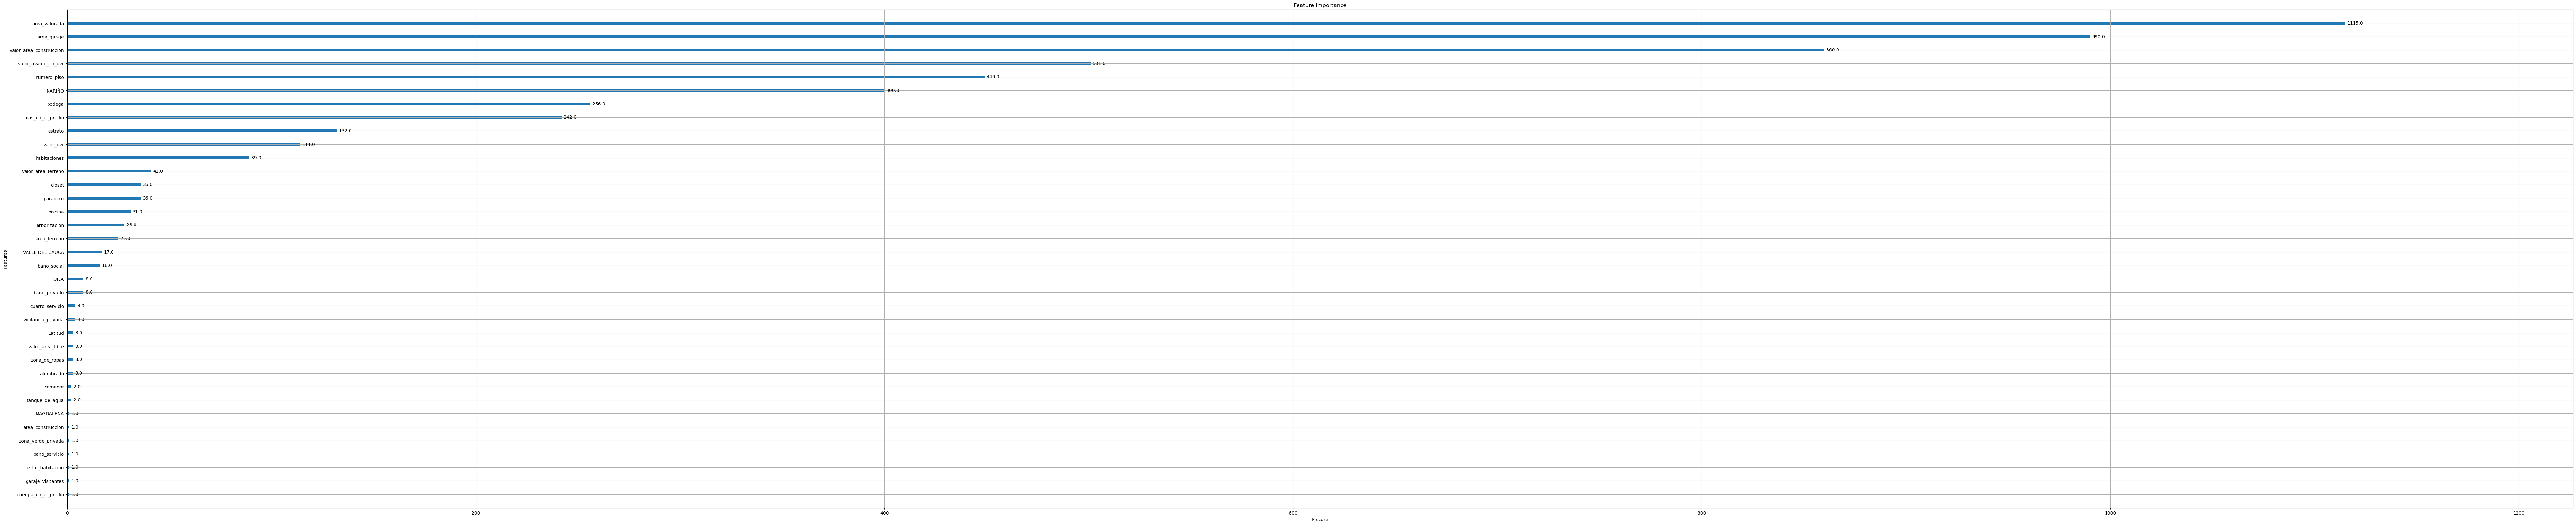

In [90]:
xgb.plot_importance(gsearch1.best_estimator_)
plt.rcParams['figure.figsize'] = [100, 20]
plt.show()

## Entrenamiento con variables más importantes

In [97]:
model = xgb_estimator2.fit(X_train,y_train)

dict_features = model.get_booster().get_score(importance_type='weight')

In [111]:
variables_ordenadas = dict(sorted(dict_features.items(), key=lambda item: item[1]))
variables_importantes = [x for x in list(reversed(list(variables_ordenadas)))[0:20]]

In [117]:
df_best = df_num_[variables_importantes]
df_best['Y'] = y

/tmp/ipykernel_7461/1999180500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_best['Y'] = y


<AxesSubplot:>

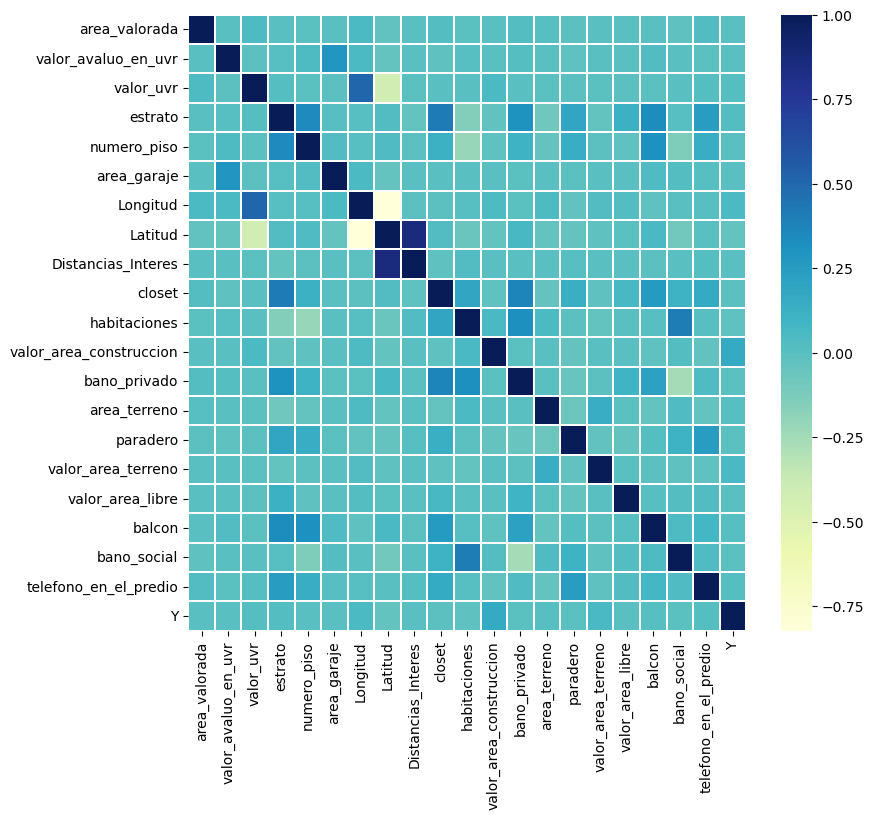

In [119]:
corrmat = df_best.corr()
  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [120]:
df_best['Y'].describe()

count    3.346000e+03
mean     3.623486e+09
std      1.096876e+11
min      0.000000e+00
25%      1.160940e+08
50%      1.804380e+08
75%      3.030359e+08
max      5.744320e+12
Name: Y, dtype: float64

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

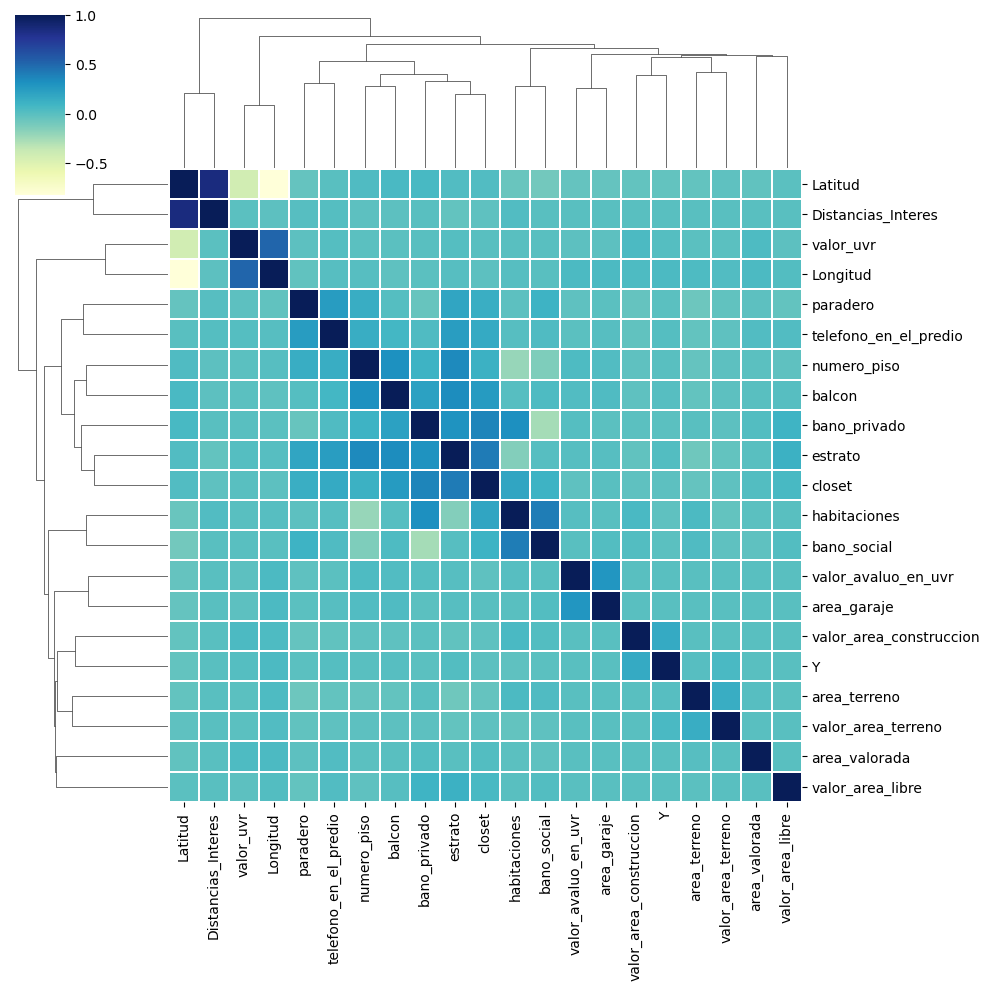

In [121]:
corrmat = df_best.corr()
  
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1);
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)

In [122]:
df_best = df_best.drop('Y', axis=1)

X_best = df_best

X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.25, random_state=42, shuffle=True)

params1 = {
    'n_estimators':[500],
    'max_depth':[3,5],
    'learning_rate':np.linspace(0.001,0.1,2),
    'gamma':np.linspace(0,1,2),#
    'min_child_weight':np.linspace(1,5,2),#
    'subsample':np.linspace(0.3,0.9,2), # 
    'colsample_bytree':np.linspace(0.3,0.9,2),#
}


xgb_estimator1 = XGBRegressor(seed=42)

xgb_estimator2 = XGBRegressor(learning_rate =0.1, n_estimators=1000,
      subsample=0.6, colsample_bytree=0.6,seed=42)

gsearch1 = GridSearchCV(estimator=xgb_estimator1,param_grid=params1,
                       scoring='neg_mean_absolute_percentage_error',n_jobs=-1,
                       refit='neg_mean_absolute_percentage_error',cv=4,verbose=11)

xgb_estimator2.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

## Métrica MAPE 

In [123]:
preds = xgb_estimator2.predict(X_test)

print(np.sqrt(mean_absolute_percentage_error(preds, y_test)))
print(mean_absolute_percentage_error(preds, y_test))

2.578293324722344
6.647596468307798


In [125]:
gsearch1.fit(X_train,y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
[CV 1/4; 1/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.3
[CV 2/4; 1/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.3
[CV 3/4; 1/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.3
[CV 4/4; 1/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.3
[CV 1/4; 2/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.9
[CV 2/4; 2/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1.0, n_estimators=500, subsample=0.9
[CV 4/4; 2/64] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=3

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': array([0.3, 0.9]),
                         'gamma': array([0., 1.]),
                         'learning_rate': array([0.001, 0.1  ]),
           

In [126]:
preds2 = gsearch1.predict(X_test)

print(np.sqrt(mean_absolute_percentage_error(preds2, y_test)))
print(mean_absolute_percentage_error(preds2, y_test))

5.523554522426331
30.509654562216376


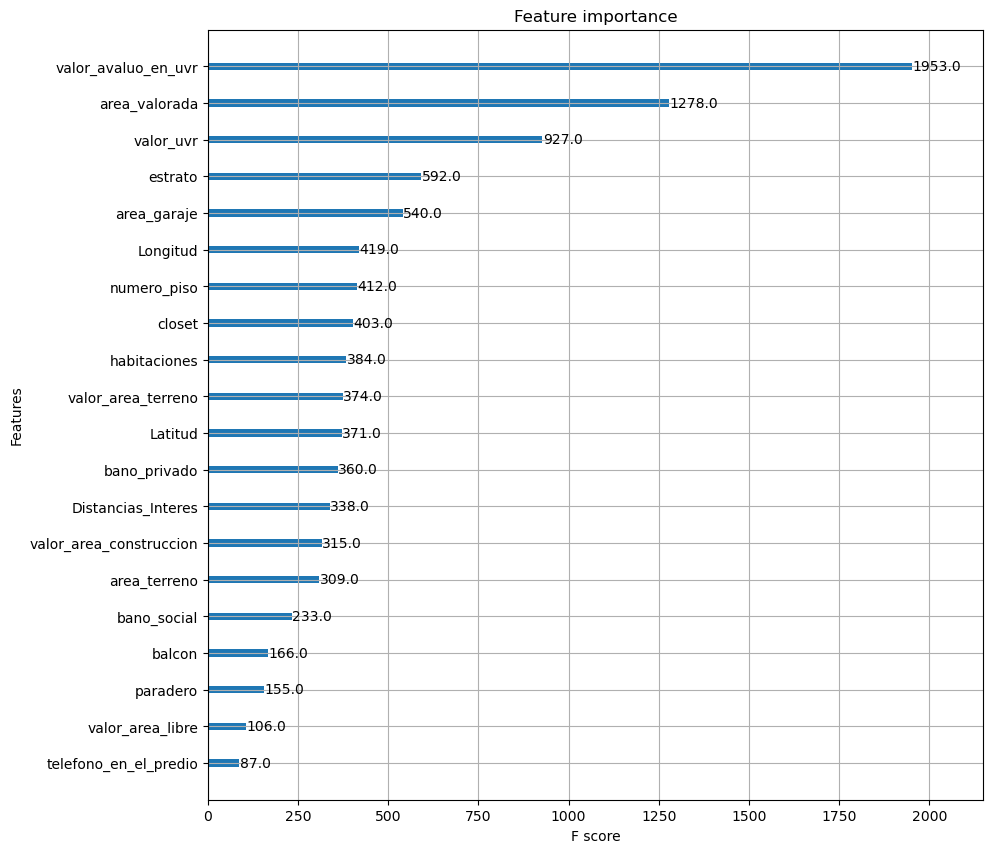

In [130]:
xgb.plot_importance(gsearch1.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 15]
plt.show()